## **Table 24. Dependencies**

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
!pip install arch
import arch
from arch import arch_model
import itertools
from tabulate import tabulate
import scipy.stats as stats
import math
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas_datareader import data as pdr
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.tsa.stattools as ts
import seaborn as sns
from scipy.stats import t
from scipy.optimize import newton

## **Table 25. Implied volatility using hypothetical options price**

In [2]:
start = dt.datetime(2023, 1, 1)
end = dt.datetime(2025, 1, 1)

data = pdr.get_data_fred('DHHNGSP', start = start, end = end).dropna()
S0 = data.iloc[-1].values[0]
print('S0 (Spot Price):', S0)

risk_free_rate = pdr.get_data_fred('DTB3', start = start, end = end).dropna()
r = risk_free_rate.iloc[-1].values[0] / 100
print('Risk-Free Rate (r):', r)

S0 (Spot Price): 3.4
Risk-Free Rate (r): 0.042300000000000004


In [3]:
def BS_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

options_data = pd.DataFrame({
    'Strike Price': [4.0, 4.5, 5.0, 5.5],
    'Option Price': [0.25, 0.30, 0.20, 0.15],
    'Time to Expiration': [0.25, 0.5, 0.75, 1.0]})

implied_volatilities = []
for index, row in options_data.iterrows():
    option_price = row['Option Price']
    K = row['Strike Price']
    T = row['Time to Expiration']

    # Implied volatility using Newton's method
    try:
        implied_vol = newton(
            lambda sigma: BS_call(S0, K, T, r, sigma) - option_price,
            0.5,
            tol = 1e-5)
        implied_volatilities.append(implied_vol)
    except RuntimeError:
        implied_volatilities.append(np.nan)

options_data['Implied Volatility'] = implied_volatilities
print(options_data)

   Strike Price  Option Price  Time to Expiration  Implied Volatility
0           4.0          0.25                0.25            0.655624
1           4.5          0.30                0.50            0.634867
2           5.0          0.20                0.75            0.497947
3           5.5          0.15                1.00            0.436269


## **Table 27. Rolling window realized volatility**

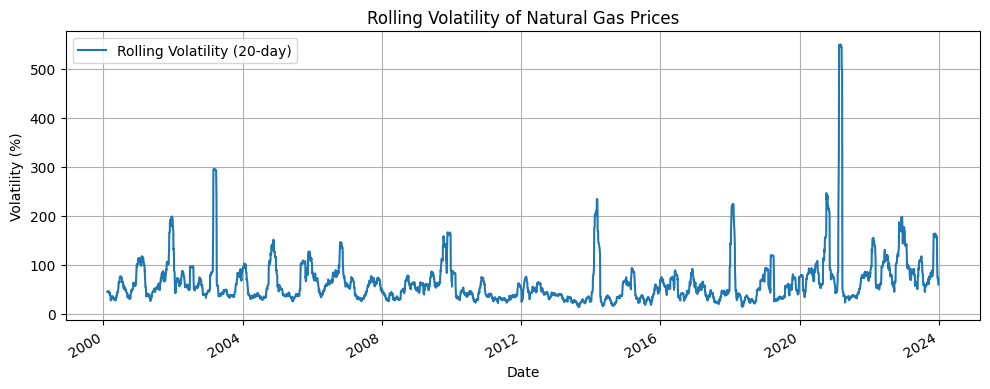

In [4]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2023, 12, 31)
data = pdr.get_data_fred('DHHNGSP', start = start, end = end).dropna()

data.index = pd.to_datetime(data.index)
data = data.asfreq('D')

data['Returns'] = np.log(data['DHHNGSP'] / data['DHHNGSP'].shift(1)) * 100
data.dropna(inplace=True)

data['Rolling_Volatility'] = data['Returns'].rolling(window = 20).std() * np.sqrt(252)
data.dropna(inplace=True)

data['Rolling_Volatility'].plot(figsize=(10, 4), label = 'Rolling Volatility (20-day)')
plt.title('Rolling Volatility of Natural Gas Prices')
plt.ylabel('Volatility (%)')
plt.xlabel('Date')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

## **Table 28. Daily, Monthly and Annual historical volatility**

In [5]:
daily_volatility = data['Returns'].std()
monthly_volatility = math.sqrt(21) * daily_volatility
annual_volatility = math.sqrt(252) * daily_volatility
table_data = [
    ["Daily Volatility", daily_volatility],
    ["Monthly Volatility", monthly_volatility],
    ["Annual Volatility", annual_volatility]]
table = tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid")
print(table)

╒════════════════════╤═════════╕
│ Metric             │   Value │
╞════════════════════╪═════════╡
│ Daily Volatility   │  5.0472 │
├────────────────────┼─────────┤
│ Monthly Volatility │ 23.1292 │
├────────────────────┼─────────┤
│ Annual Volatility  │ 80.1218 │
╘════════════════════╧═════════╛


In [6]:
data.head()

,DHHNGSP,Returns,Rolling_Volatility
DATE,,,
2000-02-09,2.62,0.766287,45.448958
2000-02-10,2.65,1.138532,45.404369
2000-02-11,2.65,0.000000,45.511880
2000-02-15,2.61,0.000000,45.615736
2000-02-16,2.65,1.520942,45.636868


## **Table 29. Test for unit root**

In [7]:
adf_result = ts.adfuller(data['DHHNGSP'])
table_data = [
    ["ADF Statistic", adf_result[0]],
    ["p-value", adf_result[1]],
    ["Critical Values (1%)", adf_result[4]['1%']],
    ["Critical Values (5%)", adf_result[4]['5%']],
    ["Critical Values (10%)", adf_result[4]['10%']]]

table = tabulate(table_data, headers=["Metric", "Value"], tablefmt="fancy_grid")
print(table)

╒═══════════════════════╤═════════════╕
│ Metric                │       Value │
╞═══════════════════════╪═════════════╡
│ ADF Statistic         │ -4.04639    │
├───────────────────────┼─────────────┤
│ p-value               │  0.00118615 │
├───────────────────────┼─────────────┤
│ Critical Values (1%)  │ -3.43174    │
├───────────────────────┼─────────────┤
│ Critical Values (5%)  │ -2.86215    │
├───────────────────────┼─────────────┤
│ Critical Values (10%) │ -2.5671     │
╘═══════════════════════╧═════════════╛


## **Table 30. Distribution of daily returns**

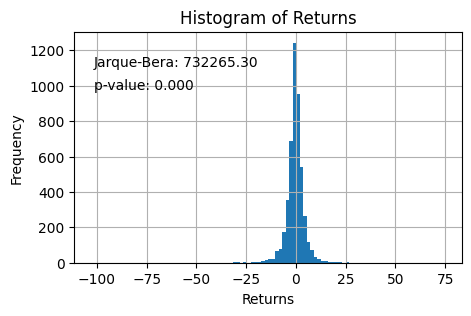

In [8]:
plt.figure(figsize=(5,3))
plt.hist(data['Returns'], bins=100)
plt.title('Histogram of Returns')
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid()

# Jarque-Bera test
jb_statistic, p_value = stats.jarque_bera(data['Returns'])

plt.text(0.05, 0.85, f'Jarque-Bera: {jb_statistic:.2f}', transform=plt.gca().transAxes)
plt.text(0.05, 0.75, f'p-value: {p_value:.3f}', transform=plt.gca().transAxes)
plt.show()

## **Table 31. ARCH Lagrange Multiplier (LM) test**

In [9]:
model = arch.arch_model(data['Returns'], vol = 'GARCH', p = 1, q = 1, rescale = False)
results = model.fit(disp='off',show_warning = False)
residuals = results.resid
squared_residuals = residuals**2
arch_test = sm.stats.diagnostic.het_arch(squared_residuals)

table_data = [
    ['LM Statistic', arch_test[0]],
    ['p-value', arch_test[1]],
    ['F Statistic', arch_test[2]],
    ['p-value', arch_test[3]]]

table = tabulate(table_data, headers=['Statistic', 'Value'], tablefmt='fancy_grid')
print(table)

╒══════════════╤════════════════╕
│ Statistic    │          Value │
╞══════════════╪════════════════╡
│ LM Statistic │ 602.826        │
├──────────────┼────────────────┤
│ p-value      │   4.36706e-123 │
├──────────────┼────────────────┤
│ F Statistic  │  68.9522       │
├──────────────┼────────────────┤
│ p-value      │   6.49498e-132 │
╘══════════════╧════════════════╛


## **Table 32. Fitting multiple models**

In [10]:
np.random.seed(123)

arch_1_model = arch.arch_model(data['Returns'],
                               vol = 'ARCH',
                               mean = 'Zero',
                               p = 1,
                               dist = 'skewt',
                               rescale = False).fit(disp = 'off', show_warning = False)

arch_2_model = arch.arch_model(data['Returns'],
                               mean = 'Zero',
                               vol = 'ARCH',
                               p = 2,
                               dist = 'skewt',
                               rescale = False).fit(disp = 'off', show_warning = False)

garch_model = arch.arch_model(data['Returns'],
                              mean = 'Zero',
                              vol = 'GARCH',
                              p = 1,
                              q = 1,
                              dist = 'skewt').fit(disp = 'off', show_warning = False)

# TARCH model
bic_tarch = []
best_tarch_param = (1, 1, 1)

for p in range(1, 5):
    for o in range(1, 3):
        for q in range(1, 5):
            try:
                tarch = arch_model(data['Returns'],
                                    mean = 'Zero',
                                    vol = 'GARCH',
                                    update_freq = 5,
                                    p = p,
                                    o = o,
                                    q = q,
                                    power = 1.0).fit(disp = 'off')
                bic_tarch.append(tarch.bic)
                if tarch.bic < np.min(bic_tarch):  #
                    best_tarch_param = (p, o, q)
            except:
                continue

# TARCH model with best parameters
tarch_model = arch_model(data['Returns'],
                          mean='Zero',
                          vol='GARCH',
                          p = best_tarch_param[0],
                          o = best_tarch_param[1],
                          q = best_tarch_param[2],
                          power = 1.0).fit(disp = 'off')

# EGARCH Model Selection and Fitting
bic_egarch = []
best_egarch_param = None

for p in range(1, 5):
    for o in range(1, 3):
        for q in range(1, 5):
            try:
                egarch = arch_model(data['Returns'],
                                    mean = 'Zero',
                                    vol = 'EGARCH',
                                    p = p,
                                    o = o,
                                    q = q).fit(disp = 'off')
                bic_egarch.append((egarch.bic, (p, o, q)))
            except:
                continue

# Best parameters based on BIC
if bic_egarch:
    best_bic, best_egarch_param = min(bic_egarch, key=lambda x: x[0])
else:
    print("No valid EGARCH models could be fit.")
    best_egarch_param = (1, 1, 1)

egarch_model = arch_model(data['Returns'],
                          mean = 'Zero',
                          vol = 'EGARCH',
                          p = best_egarch_param[0],
                          o = best_egarch_param[1],
                          q = best_egarch_param[2]).fit(disp = 'off')



# GJR-GARCH Model Selection and Fitting
bic_gjr_garch = []
best_gjr_garch_param = None

for p in range(1, 5):
    for o in range(1, 3):
        for q in range(1, 5):
            try:
                gjr_garch = arch_model(data['Returns'],
                                       mean = 'Zero',
                                       vol = 'GARCH',
                                       p = p,
                                       o = o,
                                       q = q).fit(disp = 'off')
                bic_gjr_garch.append((gjr_garch.bic, (p, o, q)))
            except Exception as e:
                continue

# Best model
if bic_gjr_garch:
    best_bic, best_gjr_garch_param = min(bic_gjr_garch, key = lambda x: x[0])
else:
    print("No valid GJR-GARCH models could be fit. Defaulting to (1, 1, 1).")
    best_gjr_garch_param = (1, 1, 1)

gjr_garch_model = arch_model(data['Returns'],
                             mean = 'Zero',
                             vol = 'GARCH',
                             p = best_gjr_garch_param[0],
                             o = best_gjr_garch_param[1],
                             q = best_gjr_garch_param[2]).fit(disp = 'off')


models = [arch_1_model, arch_2_model, garch_model, tarch_model, egarch_model, gjr_garch_model]
model_names = ['ARCH(1)', 'ARCH(2)', 'GARCH(1,1)', 'TARCH(p,o,q)', 'EGARCH(p,q)', 'GJR-GARCH(p,o,q)']
aic_values = [model.aic for model in models]

# Realized volatility using a rolling window
window_size = 20
data['RealizedVolatility'] = data['Returns'].rolling(window=window_size).std() * np.sqrt(252)
data.dropna(inplace = True)

rmse_values = []
rmspe_values = []

for model in models:
    conditional_volatility = model.conditional_volatility.loc[data.index]
    realized_volatility = data['RealizedVolatility']

    rmse = np.sqrt(mean_squared_error(realized_volatility, conditional_volatility))
    rmse_values.append(rmse)

    rmspe = np.sqrt(np.mean(((realized_volatility - conditional_volatility) / realized_volatility) ** 2))
    rmspe_values.append(rmspe)

table_data = [[model_names[i], aic_values[i], rmse_values[i], rmspe_values[i]] for i in range(len(models))]
print(tabulate(table_data, headers = ['Model', 'AIC', 'RMSE', 'RMSPE'],
               tablefmt = 'fancy_grid'))

╒══════════════════╤═════════╤═════════╤══════════╕
│ Model            │     AIC │    RMSE │    RMSPE │
╞══════════════════╪═════════╪═════════╪══════════╡
│ ARCH(1)          │ 25849.3 │ 76.7406 │ 0.907912 │
├──────────────────┼─────────┼─────────┼──────────┤
│ ARCH(2)          │ 25701.2 │ 76.6827 │ 0.915414 │
├──────────────────┼─────────┼─────────┼──────────┤
│ GARCH(1,1)       │ 25473.2 │ 76.0862 │ 0.926254 │
├──────────────────┼─────────┼─────────┼──────────┤
│ TARCH(p,o,q)     │ 26039.8 │ 76.6723 │ 0.928053 │
├──────────────────┼─────────┼─────────┼──────────┤
│ EGARCH(p,q)      │ 25948.4 │ 76.5194 │ 0.92817  │
├──────────────────┼─────────┼─────────┼──────────┤
│ GJR-GARCH(p,o,q) │ 25993.9 │ 76.0427 │ 0.928029 │
╘══════════════════╧═════════╧═════════╧══════════╛


## **Table 33. Parameter stats**

In [11]:
parameters = pd.DataFrame({'parameter': garch_model.params,
                           'p-value': garch_model.pvalues})

parameters

,parameter,p-value
omega,0.871252,2.973689e-07
alpha[1],0.206804,9.142478e-21
beta[1],0.772776,3.006054e-288
eta,4.200155,5.078823e-49
lambda,0.002743,8.362936e-01


## **Table 34. Realized vs Conditional volatility**

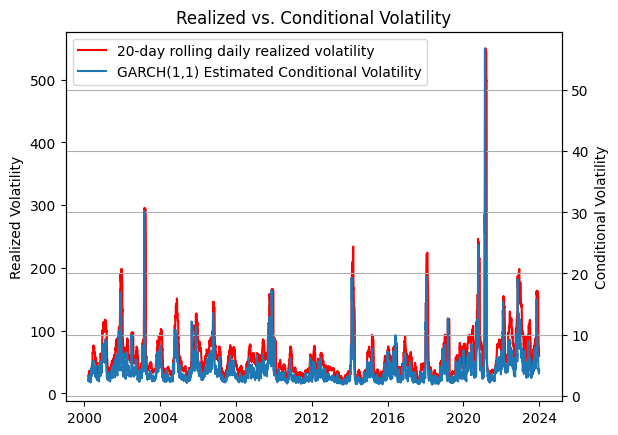

In [12]:
fig, ax1 = plt.subplots()

line1, = ax1.plot(data.index, realized_volatility, label='20-day rolling daily realized volatility', color='red')
ax1.set_ylabel('Realized Volatility')
ax1.tick_params('y')

ax2 = ax1.twinx()

line2, = ax2.plot(data.index, conditional_volatility, label='GARCH(1,1) Estimated Conditional Volatility')
ax2.set_ylabel('Conditional Volatility')
ax2.tick_params('y')

plt.title('Realized vs. Conditional Volatility')
plt.grid(True)
plt.legend(handles=[line1, line2], loc='upper left')
plt.show()

## **Table 35. Standardized residuals**

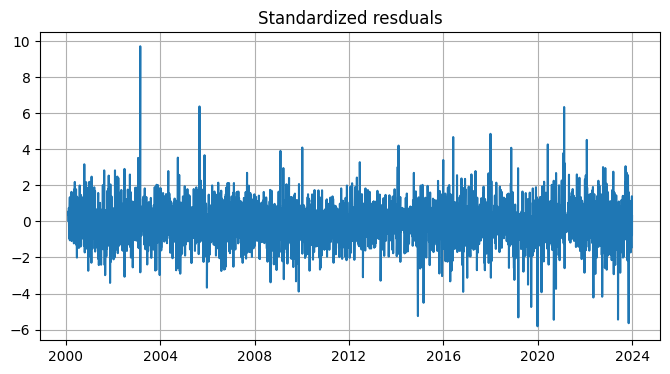

In [13]:
std_resid = garch_model.resid /garch_model.conditional_volatility
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(std_resid)
ax.set(title = 'Standardized resduals')
ax.grid()

## **Table 36. Ljung-Box test for autocorrelation**

In [14]:
lb_test = acorr_ljungbox(std_resid, lags = 10, return_df = True)
p_values = lb_test['lb_pvalue'].to_frame().T

col_num = p_values.shape[1]
col_names = ['lag_' + str(num) for num in list(range(1, col_num + 1, 1))]
p_values.columns = col_names
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lb_pvalue,0.470391,0.000581,0.001382,0.003445,0.007708,0.012661,0.021651,0.016188,0.019923,0.026104


## **Table 37. Error metrics and projected volatility for next 60 days**

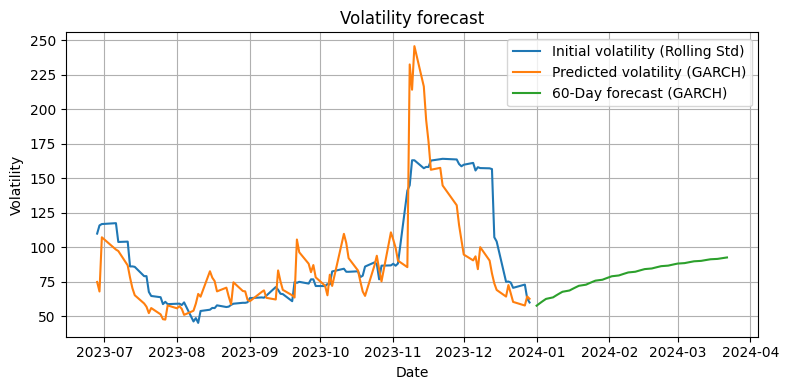

In [15]:
data['Rolling_Volatility'] = data['Returns'].rolling(window = 20).std()
data.dropna(inplace=True)

predicted_volatility = garch_model.conditional_volatility

annualized_factor = np.sqrt(252)
data['Rolling_Volatility'] = data['Rolling_Volatility'] * annualized_factor
predicted_volatility = predicted_volatility * annualized_factor
predicted_volatility = predicted_volatility.loc[predicted_volatility.index.intersection(data.index)]
data = data.loc[data.index.intersection(predicted_volatility.index)]

# Forecasting the next 60 days
forecast_horizon = 60
forecast_results = garch_model.forecast(horizon=forecast_horizon)

forecast_volatility = np.sqrt(forecast_results.variance.values[-1, :])
forecast_volatility = forecast_volatility * annualized_factor

forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='B')

last_100_data = data.iloc[-100:]
last_100_predicted_volatility = predicted_volatility[-100:]

plt.figure(figsize=(8, 4))
plt.plot(last_100_data.index, last_100_data['Rolling_Volatility'],
         label = 'Initial volatility (Rolling Std)')
plt.plot(last_100_data.index, last_100_predicted_volatility,
         label = 'Predicted volatility (GARCH)')
plt.plot(forecast_index, forecast_volatility, label = '60-Day forecast (GARCH)')
plt.title('Volatility forecast')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
predicted_volatility = predicted_volatility.loc[data.index]
mae = mean_absolute_error(data['Rolling_Volatility'], predicted_volatility)
mse = mean_squared_error(data['Rolling_Volatility'], predicted_volatility)
rmse = np.sqrt(mse)

print(f"MAE for in-sample predicted volatility: {mae:.4f}")
print(f"MSE for in-sample predicted volatility: {mse:.4f}")
print(f"RMSE for in-sample predicted volatility: {rmse:.4f}")

MAE for in-sample predicted volatility: 15.4962
MSE for in-sample predicted volatility: 793.8684
RMSE for in-sample predicted volatility: 28.1757


## **Table 38. Forecasted Volatility vs. Actual Returns Using a Fixed Rolling Window Approach**

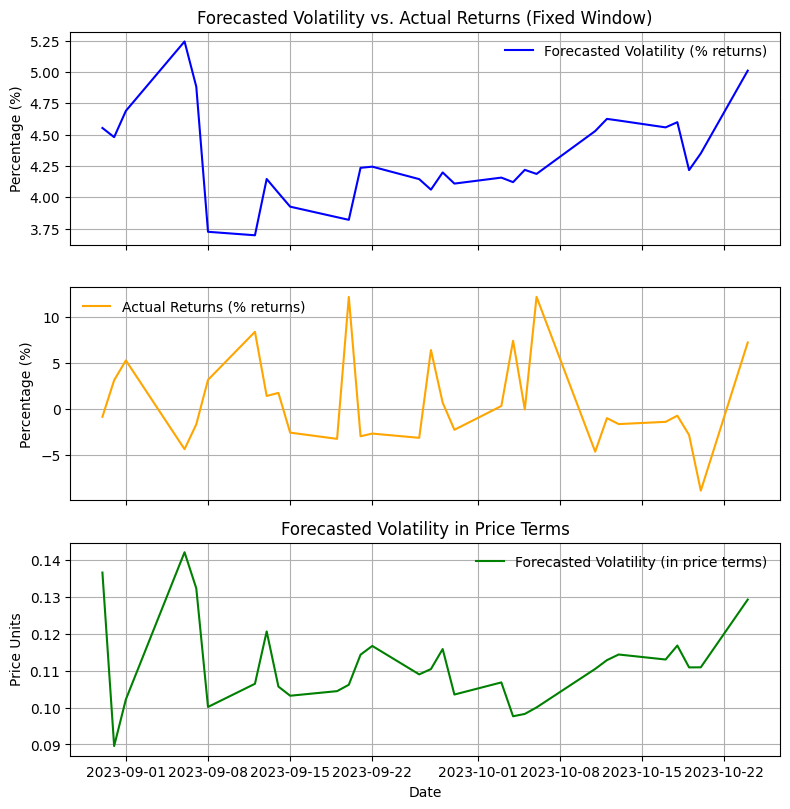

In [17]:
start_loc = int(len(data) - (252 * 0.5))
end_loc = start_loc + 60

forecasts = {}

for i in range(30):
    rolling_window_data = data.iloc[start_loc + i:end_loc + i]

    garch_result = arch_model(
        rolling_window_data['Returns'],
        vol = 'GARCH',
        p = 1,
        q = 1,
        dist = 'skewt'
    ).fit(disp = 'off', show_warning = False)

    # 1-period ahead variance forecast
    temp_result = garch_result.forecast(horizon=1).variance

    # Forecasted variance for the next step
    fcast = np.sqrt(temp_result.iloc[-1].values[0])
    forecasts[data.index[end_loc + i]] = fcast

# Create DataFrame for forecasted volatility
forecast_var_fixed = pd.DataFrame(
    list(forecasts.values()),
    index=forecasts.keys(),
    columns=['Volatility (in % returns)'])

forecast_var_fixed['Volatility (in price terms)'] = (
    forecast_var_fixed['Volatility (in % returns)'] / 100) * data['DHHNGSP'].iloc[-30:].values

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

axes[0].plot(forecast_var_fixed.index, forecast_var_fixed['Volatility (in % returns)'],
             label='Forecasted Volatility (% returns)', color = 'blue')
axes[0].set_ylabel('Percentage (%)')
axes[0].legend(frameon = False)
axes[0].set_title('Forecasted Volatility vs. Actual Returns (Fixed Window)')
axes[0].grid(True)

# Actual returns
axes[1].plot(data.iloc[start_loc + 60:end_loc + 30].index,
             data.iloc[start_loc + 60:end_loc + 30]['Returns'],
             label='Actual Returns (% returns)', color='orange')
axes[1].set_ylabel('Percentage (%)')
axes[1].legend(frameon = False)
axes[1].grid(True)

# Forecasted volatility in price terms
axes[2].plot(forecast_var_fixed.index, forecast_var_fixed['Volatility (in price terms)'],
             label='Forecasted Volatility (in price terms)', color = 'green')
axes[2].set_ylabel('Price Units')
axes[2].legend(frameon = False)
axes[2].grid(True)
axes[2].set_title('Forecasted Volatility in Price Terms')
fig.tight_layout()
plt.xlabel('Date')
plt.show()

## **Table 39. Forecasted Volatility vs. Actual Returns Using Expanding Window Approach**

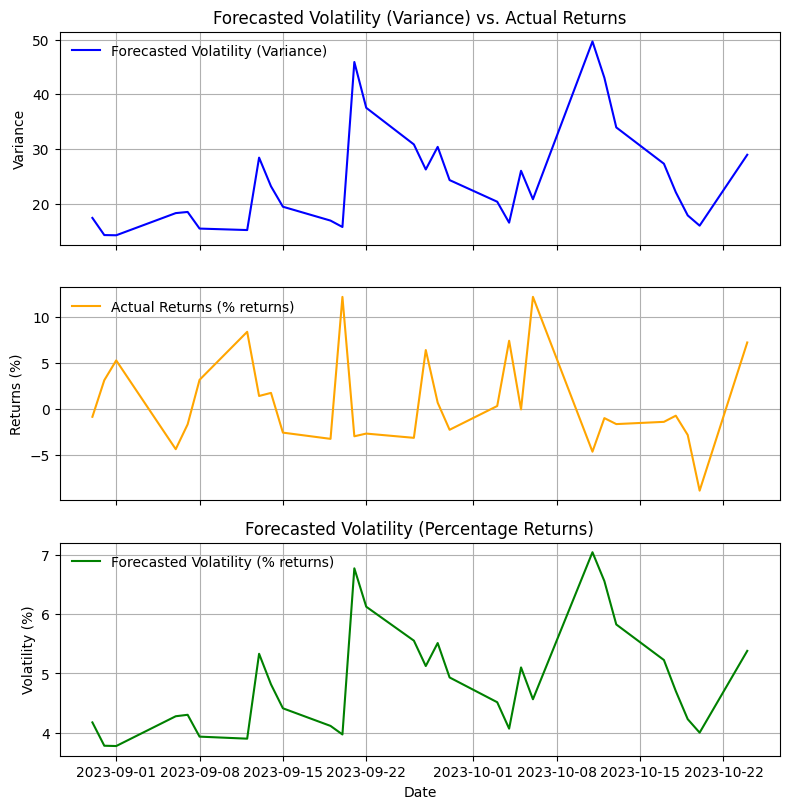

In [18]:
start_loc = len(data) - round(0.5 * 252)
end_loc = start_loc + 60

forecasts = {}

for i in range(30):
    expanding_window_data = data.iloc[:start_loc + 60 + i]

    expanding_rolling_result = arch.arch_model(
        expanding_window_data['Returns'],
        vol = 'GARCH',
        p = 1,
        q = 1,
        dist = 'skewt'
    ).fit(disp = 'off', show_warning = False)

    # Forecast 1-period volatility
    temp_result_expanding = expanding_rolling_result.forecast(horizon=1).variance

    forecast_index = data.index[start_loc + 60 + i]
    fcast = temp_result_expanding.iloc[-1].values[0]
    forecasts[forecast_index] = fcast

forecast_var_expanding = pd.DataFrame(
    list(forecasts.values()),
    index=forecasts.keys(),
    columns=['Variance'])

fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

# Forecasted volatility
axes[0].plot(forecast_var_expanding.index, forecast_var_expanding['Variance'],
             label = 'Forecasted Volatility (Variance)', color = 'blue')
axes[0].set_ylabel('Variance')
axes[0].legend(frameon=False)
axes[0].set_title('Forecasted Volatility (Variance) vs. Actual Returns')
axes[0].grid(True)

# Actual returns in percentage terms
axes[1].plot(data.iloc[start_loc + 60:start_loc + 60 + 30].index,
             data.iloc[start_loc + 60:start_loc + 60 + 30]['Returns'],
             label='Actual Returns (% returns)', color='orange')
axes[1].set_ylabel('Returns (%)')
axes[1].legend(frameon = False)
axes[1].grid(True)

# Forecasted volatility in percentage terms (as sqrt of variance)
axes[2].plot(forecast_var_expanding.index, np.sqrt(forecast_var_expanding['Variance']),
             label='Forecasted Volatility (% returns)', color='green')
axes[2].set_ylabel('Volatility (%)')
axes[2].legend(frameon = False)
axes[2].set_title('Forecasted Volatility (Percentage Returns)')
axes[2].grid(True)

fig.tight_layout()
plt.xlabel('Date')
plt.show()

## **Table 40. ARIMA model with optimal p,d,q orders**

In [19]:
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2023, 12, 31)
data = pdr.get_data_fred('DHHNGSP', start=start, end=end)
data.index = pd.to_datetime(data.index)
data = data.asfreq('D')
data.dropna(inplace=True)

p_values = range(0, 3)
d_values = [1]
q_values = range(0, 3)

best_aic = float('inf')
best_order = None

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(data.values, order = (p, d, q))
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = (p, d, q)
    except:
        continue
print(f"Best ARIMA order: {best_order}, AIC: {best_aic}")

Best ARIMA order: (2, 1, 2), AIC: 5462.217221854951


In [20]:
model = ARIMA(data.values,
              order = best_order)
results = model.fit(method_kwargs={'maxiter': 1000})
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6031
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2726.109
Date:                Sun, 19 Jan 2025   AIC                           5462.217
Time:                        01:42:47   BIC                           5495.740
Sample:                             0   HQIC                          5473.856
                               - 6031                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0139      0.019     -0.736      0.462      -0.051       0.023
ar.L2          0.2206      0.019     11.673      0.000       0.184       0.258
ma.L1         -0.0802      0.019     -4.333      0.0

## **Table 41. Ljung-Box test for autocorrelation**

In [21]:
arima_residuals = results.resid
lb_test = acorr_ljungbox(arima_residuals, lags=10, return_df=True)
p_values = lb_test['lb_pvalue'].to_frame().T

col_num = p_values.shape[1]
col_names = ['lag_' + str(num) for num in list(range(1, col_num + 1, 1))]
p_values.columns = col_names
p_values

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10
lb_pvalue,0.845715,0.980194,0.630226,0.754584,0.324678,0.287291,0.357646,0.253496,0.337102,0.326068


## **Table 42. GARCH model using residuals from ARIMA**

In [22]:
garch_model = arch.arch_model(arima_residuals,
                              vol='GARCH',
                              p=1,
                              q=1,
                              dist='skewt').fit()
print("\nGARCH Summary:")
print(garch_model.summary())

Iteration:      1,   Func. Count:      8,   Neg. LLF: 102614.07939406265
Iteration:      2,   Func. Count:     22,   Neg. LLF: -2533.609034402996
Optimization terminated successfully    (Exit mode 0)
            Current function value: -2533.6090307112236
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2

GARCH Summary:
                           Constant Mean - GARCH Model Results                           
Dep. Variable:                                 y   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:                2533.61
Distribution:      Standardized Skew Student's t   AIC:                          -5055.22
Method:                       Maximum Likelihood   BIC:                          -5014.99
                                                   No. Observations:                 6031

## **Table 43. Forecasted residual variance for the last 3 days, projected for the next 5 periods**

In [23]:
forecasts = garch_model.forecast(horizon=5)
print(forecasts.residual_variance.iloc[-3:])

           h.1       h.2      h.3       h.4       h.5
6030  0.021047  0.023534  0.02597  0.028358  0.030699


## **Table 44. ARIMA-GARCH forecasting**

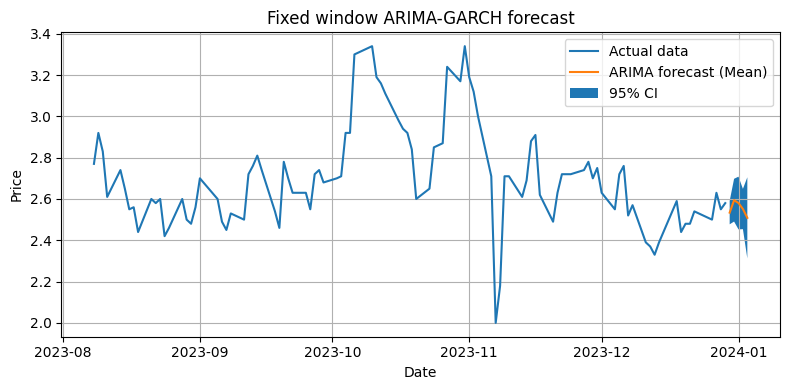

In [24]:
window_size = 20
forecast_horizon = 5
best_order = best_order

forecasts_mean = []
forecasts_volatility = []
forecast_dates = []

for i in range(forecast_horizon):
    if i == 0:
        window_data = data['DHHNGSP'][-window_size:]
    else:
        window_data = data['DHHNGSP'][-(window_size + i):-i]

    if len(window_data) < window_size:
        print(f"Insufficient data for window at step {i}. Skipping...")
        break

    arima_model = ARIMA(window_data, order=best_order)
    try:
        arima_results = arima_model.fit(method_kwargs={'maxiter': 500})
    except Exception as e:
        print(f"ARIMA model failed at step {i}: {e}")
        break

    arima_residuals = arima_results.resid
    current_garch_model = arch.arch_model(arima_residuals,
                                          vol = 'GARCH',
                                          p = 1,
                                          q = 1,
                                          dist = 'skewt')
    try:
        garch_results = current_garch_model.fit(disp='off')
    except Exception as e:
        print(f"GARCH model failed at step {i}: {e}")
        break

    # Forecast mean and volatility
    try:
        arima_forecast = arima_results.forecast(steps=1)
        garch_forecast = garch_results.forecast(horizon=1).variance.iloc[-1, 0]
    except Exception as e:
        print(f"Forecasting failed at step {i}: {e}")
        break

    forecasts_mean.append(arima_forecast.iloc[0])
    forecasts_volatility.append(np.sqrt(garch_forecast))
    forecast_dates.append(data.index[-1] + pd.DateOffset(days=i + 1))

plt.figure(figsize=(8, 4))
plt.plot(data.index[-100:], data['DHHNGSP'][-100:], label='Actual data')
plt.plot(forecast_dates, forecasts_mean, label='ARIMA forecast (Mean)')
lower_bound = np.array(forecasts_mean) - 1.96 * np.array(forecasts_volatility)
upper_bound = np.array(forecasts_mean) + 1.96 * np.array(forecasts_volatility)
plt.fill_between(forecast_dates, lower_bound, upper_bound, label='95% CI')
plt.title('Fixed window ARIMA-GARCH forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## **Table 45. ARIMA-GARCH Forecasting Performance: Actual vs. Predicted Variance**

╒═════════════╤════════╤═════════╤═════════╕
│ Model       │    MAE │     MSE │ RMSPE   │
╞═════════════╪════════╪═════════╪═════════╡
│ ARIMA-GARCH │ 0.0187 │ 0.00072 │ 13.7%   │
╘═════════════╧════════╧═════════╧═════════╛


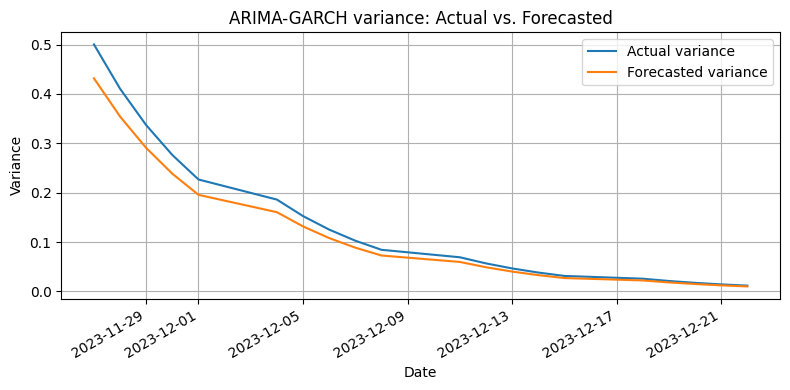

In [25]:
date_index = garch_results.conditional_volatility.index
actual_var = garch_results.conditional_volatility ** 2
forecast_horizon = len(actual_var)
garch_forecast = garch_results.forecast(horizon=1, start=0)
forecast_var = garch_forecast.variance.iloc[:, 0]
actual_var = np.array(actual_var)
forecast_var = np.array(forecast_var)

def evaluate(observation, forecast):
    mae = mean_absolute_error(observation, forecast)
    mse = mean_squared_error(observation, forecast)
    rmspe = np.sqrt(np.mean(np.square(((observation - forecast) / observation)))) * 100
    return mae, mse, rmspe

mae, mse, rmspe = evaluate(actual_var, forecast_var)
table_data = [
    ["Model", "MAE", "MSE", "RMSPE"],
    ["ARIMA-GARCH", f"{mae:.3g}", f"{mse:.3g}", f"{rmspe:.3g}%"]]
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))

plt.figure(figsize=(8, 4))
plt.plot(date_index, actual_var, label="Actual variance")
plt.plot(date_index[:len(forecast_var)], forecast_var, label="Forecasted variance")
plt.title("ARIMA-GARCH variance: Actual vs. Forecasted")
plt.xlabel("Date")
plt.ylabel("Variance")
plt.xticks(rotation=30, ha='right')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## **Table 46.One-step-ahead forecast iterated for 5 steps**

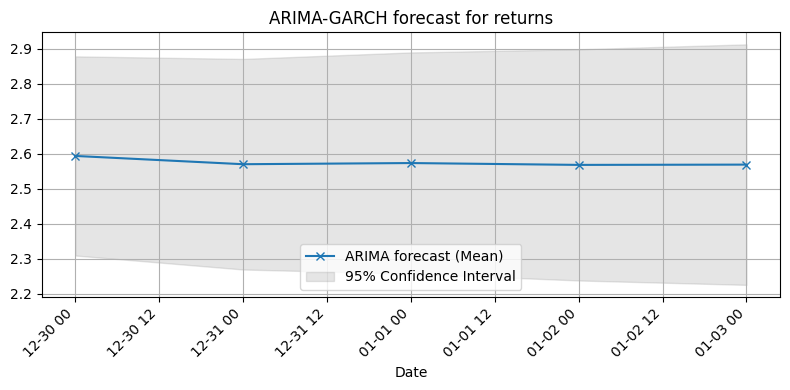

In [26]:
arima_forecast = results.forecast(steps=5)
garch_forecast = garch_model.forecast(horizon=5)

forecast_mean = arima_forecast
forecast_volatility = np.sqrt(garch_forecast.variance.iloc[-1].values)

last_date = data.index[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(days = 1), periods = 5)
plt.figure(figsize = (8, 4))
plt.plot(forecast_dates, forecast_mean, label = 'ARIMA forecast (Mean)', marker = 'x')
plt.fill_between(
    forecast_dates,
    forecast_mean - 1.96 * forecast_volatility,
    forecast_mean + 1.96 * forecast_volatility,
    color='gray', alpha = 0.2, label = '95% Confidence Interval')
plt.title('ARIMA-GARCH forecast for returns')
plt.legend()
plt.grid()
plt.xlabel('Date')
plt.xticks(rotation = 45, ha = 'right')
plt.tight_layout()
plt.show()

## **Table 47. Parametric and empirical VaR estimation**

In [27]:
confidence_level = 0.95
z_alpha = -1.645
quantile = 1 - confidence_level

VaR_parametric = forecast_mean + z_alpha * forecast_volatility
print(f"Parametric VaR at {confidence_level*100}% confidence: {VaR_parametric}")

standardized_residuals = garch_model.resid / garch_model.conditional_volatility

VaR_empirical = np.percentile(standardized_residuals, 100 * quantile)
VaR_empirical_volatility = forecast_volatility * VaR_empirical
VaR_empirical_mean = forecast_mean + VaR_empirical_volatility
print(f"Empirical VaR at {confidence_level*100}% confidence: {VaR_empirical_mean}")

Parametric VaR at 95.0% confidence: [2.35487894 2.31754711 2.3081177  2.29093858 2.28053908]
Empirical VaR at 95.0% confidence: [2.40945274 2.37525465 2.36873934 2.35428609 2.34644866]


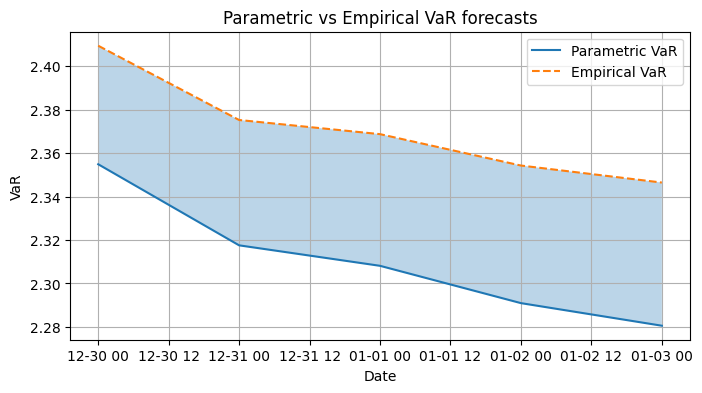

In [28]:
VaR_parametric_vals = forecast_mean + z_alpha * forecast_volatility
VaR_empirical_vals = forecast_mean + forecast_volatility * np.percentile(standardized_residuals, 100 * quantile)

plt.figure(figsize=(8, 4))
plt.plot(forecast_dates, VaR_parametric_vals, label='Parametric VaR')
plt.plot(forecast_dates, VaR_empirical_vals, label='Empirical VaR', linestyle='--')
plt.fill_between(forecast_dates, VaR_parametric_vals, VaR_empirical_vals, alpha=0.3)
plt.title('Parametric vs Empirical VaR forecasts')
plt.xlabel('Date')
plt.ylabel('VaR')
plt.legend()
plt.grid(True)
plt.show()

## **Table 48. Evaluating the Parametric Value at Risk (VaR)**

In [29]:
forecast_mean_last5 = forecast_mean[-5:]
forecast_volatility_last5 = forecast_volatility[-5:]
confidence_level = 0.05
z_alpha = stats.norm.ppf(confidence_level)

VaR_df = pd.DataFrame({
    'Forecast_Mean': forecast_mean_last5,
    'Forecast_Volatility': forecast_volatility_last5}, index=data.index[-5:])
VaR_df['VaR_Parametric'] = -(VaR_df['Forecast_Mean'] + z_alpha * VaR_df['Forecast_Volatility'])

returns_last5 = np.log(data['DHHNGSP'] / data['DHHNGSP'].shift(1)).dropna()[-5:]

table_data = pd.DataFrame({
    'Spot Price': data['DHHNGSP'][-5:],
    '5% VaR (Parametric)': VaR_df['VaR_Parametric'],
    'Return': returns_last5.values}, index=returns_last5.index)

table_data = table_data.reset_index()
table_data['Breach'] = table_data['Spot Price'] < table_data['5% VaR (Parametric)']
print(tabulate(table_data, headers='keys', tablefmt='fancy_grid'))

╒════╤═════════════════════╤══════════════╤═══════════════════════╤════════════╤══════════╕
│    │ DATE                │   Spot Price │   5% VaR (Parametric) │     Return │ Breach   │
╞════╪═════════════════════╪══════════════╪═══════════════════════╪════════════╪══════════╡
│  0 │ 2023-12-22 00:00:00 │         2.54 │              -2.3549  │  0.0239055 │ False    │
├────┼─────────────────────┼──────────────┼───────────────────────┼────────────┼──────────┤
│  1 │ 2023-12-26 00:00:00 │         2.5  │              -2.31757 │ -0.0158733 │ False    │
├────┼─────────────────────┼──────────────┼───────────────────────┼────────────┼──────────┤
│  2 │ 2023-12-27 00:00:00 │         2.63 │              -2.30814 │  0.0506931 │ False    │
├────┼─────────────────────┼──────────────┼───────────────────────┼────────────┼──────────┤
│  3 │ 2023-12-28 00:00:00 │         2.55 │              -2.29096 │ -0.0308905 │ False    │
├────┼─────────────────────┼──────────────┼───────────────────────┼────────────┼

In [30]:
VaR_df_future = pd.DataFrame({
    'Forecasted Mean': forecasts_mean,
    'Forecast_Volatility': forecasts_volatility}, index=forecast_dates)

print(tabulate(VaR_df_future, headers='keys', tablefmt='fancy_grid'))

╒═════════════════════╤═══════════════════╤═══════════════════════╕
│                     │   Forecasted Mean │   Forecast_Volatility │
╞═════════════════════╪═══════════════════╪═══════════════════════╡
│ 2023-12-30 00:00:00 │           2.53396 │             0.028901  │
├─────────────────────┼───────────────────┼───────────────────────┤
│ 2023-12-31 00:00:00 │           2.59422 │             0.0528225 │
├─────────────────────┼───────────────────┼───────────────────────┤
│ 2024-01-01 00:00:00 │           2.58045 │             0.0651671 │
├─────────────────────┼───────────────────┼───────────────────────┤
│ 2024-01-02 00:00:00 │           2.55146 │             0.0498005 │
├─────────────────────┼───────────────────┼───────────────────────┤
│ 2024-01-03 00:00:00 │           2.50862 │             0.100231  │
╘═════════════════════╧═══════════════════╧═══════════════════════╛
